## Module 1 : Fetch Data

In [1]:
# Import modules
# Read data
import os
import sys
import pickle

# Dataframes
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import concat
# display and formatting
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# Stats
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from scipy.optimize import curve_fit
import numpy.polynomial.polynomial as poly

# Config
folder = './data/'
train = 'train_aWnotuB.csv'
test = 'test_BdBKkAj_L87Nc3S.csv'
sub = 'sample_submission_KVKNmI7.csv'


def _ReadCsv_pd(datafolder, file):
    """Read CSV file from remote path.
    Returns:
      The contents of CSV file.
    Raises:
      ValueError: Unable to read file
    """
    try:
        df = pd.read_csv(os.path.join(datafolder, file))
        print(file, ": Read csv to dataframe sucessfully")
        print("Shape of dataframe", df.shape, "Memory Usage", sys.getsizeof(df))
    except Exception as e:
        raise type(e)(e)
        exit()
    return(df)

df = _ReadCsv_pd(folder, train)
# df_copy = df.copy()

def __GetTimeSeriesCount(df, col_name):
    try:
        print(pd.concat(g for _, g in df.groupby() if len(g) > 1))
        
    except:
        print("Dataframe is single timeseries")
    return()

__GetTimeSeriesCount(df,"DateTime")
# df.rename(columns={'DateTime': 'datetime'}, inplace=True)
df.head()

train_aWnotuB.csv : Read csv to dataframe sucessfully
Shape of dataframe (48120, 4) Memory Usage 4812160
Dataframe is single timeseries


,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


## Module 2 : Clean Data

In [2]:
def __GetIntCols(df, collist):
    for col in collist:
        df[col] = df[col].str.extract('(\d+)').astype(float)
    return(df)

def get_prop_missing_values(df):
    print("Null info in data: ", df.isna().any().sum())
    #prop_missing = round((df[df.columns[:]].isnull().sum()/df[df.columns[:]].count())*100,4)
    prop_missing = round((df.isnull().sum()/len(df))*100,2)
    print("These are the missing values proportions in each column")
    print(prop_missing)
    return()


def __SetColumnTypes(df, change_to_int_list = ['col1']):
    cols = df.columns
    try:
        df = __GetIntCols(df, change_to_int_list)
    except:
        pass
    # Check for any null values in the data
    print("% Missing data in each column \n",get_prop_missing_values(df))
    return(df, cols)


# For this particular dataframe

df['DateTime'] = pd.to_datetime(df['DateTime'])
clean_df, cols = __SetColumnTypes(df)

# Get list of column by types
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = list(set(cols) - set(num_cols))
cat_cols.remove('DateTime')
print(cat_cols)

Null info in data:  0
These are the missing values proportions in each column
DateTime   0.00
Junction   0.00
Vehicles   0.00
ID         0.00
dtype: float64
% Missing data in each column 
 ()
[]


In [3]:
def __CheckMissingTimeSteps(dfs, group_col):
    tdf = pd.DataFrame({'date': pd.date_range(start='2015-11-01 00:00:00', end='2017-06-30 23:00:00', freq='H')})
    len_tdf = len(tdf)
    vals = dfs[group_col].unique()
    for i in vals:
        if len(dfs[dfs[group_col] == i]) == len_tdf:
            print("No missing timesteps for group", i)
        else:
            print("Missing timesteps for group", i)
            print("Group len VS Timesteps")
            print(len(dfs[dfs[group_col] == i]), len_tdf)
    return()

__CheckMissingTimeSteps(clean_df, group_col='Junction')

#Since we see missing timesteps in group 4, we checked and found that group4 started at later date. Checking again:

def __CheckMissingTimeSteps(dfs, group_col):
    tdf = pd.DataFrame({'date': pd.date_range(start='2017-01-01 00:00:00', end='2017-06-30 23:00:00', freq='H')})
    len_tdf = len(tdf)
    vals = dfs[group_col].unique()
    for i in vals:
        if len(dfs[dfs[group_col] == i]) == len_tdf:
            print("No missing timesteps for group", i)
        else:
            print("Missing timesteps for group", i)
            print("Group len VS Timesteps")
            print(len(dfs[dfs[group_col] == i]), len_tdf)
    return()

__CheckMissingTimeSteps(clean_df[clean_df['Junction'] == 4], group_col='Junction')

No missing timesteps for group 1
No missing timesteps for group 2
No missing timesteps for group 3
Missing timesteps for group 4
Group len VS Timesteps
4344 14592
No missing timesteps for group 4


()

## Module 3 : Pre-Proccess Model Data

In [4]:
# Helper functions
# Split dataframe
def __SplitTrainTest(X, prop = 0.95):
    '''Takes in the dataframe and proprtion of train size and returns the train and test sets'''
    X.sort_values(by='ds', ascending=True, inplace = True)
    train_size = int(len(X) * prop)
    train, test = X[0:train_size], X[train_size:len(X)]
    print("Min date train main", train.ds.min(), "Max date train main", train.ds.max())
    print("Min date test main", test.ds.min(), "Max date test main", test.ds.max())
    print("Length of train", len(train), "Length of test", len(test))
    return(train, test)

clean_df.rename(columns={'DateTime': 'ds'}, inplace=True)
train_df, test_df = __SplitTrainTest(clean_df, prop = 0.80)

Min date train main 2015-11-01 00:00:00 Max date train main 2017-03-22 17:00:00
Min date test main 2017-03-22 18:00:00 Max date test main 2017-06-30 23:00:00
Length of train 38496 Length of test 9624


## Module 4 : Exploratory Data Analysis

Distribution for
a
Cat col not found


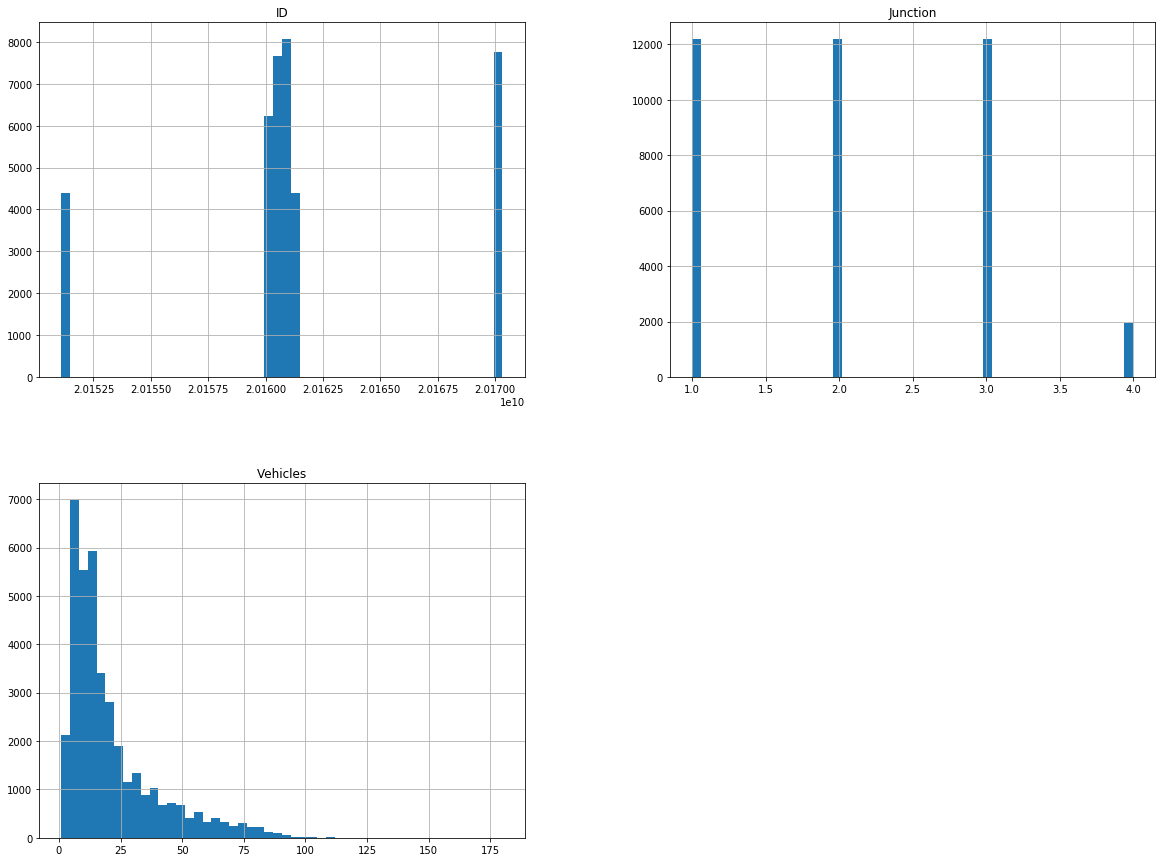

,Junction,Vehicles,ID
count,38496.00,38496.00,38496.00
mean,2.10,21.17,20161503534.75
std,0.91,18.43,5290818.03
min,1.00,1.00,20151101001.00
25%,1.00,9.00,20160313159.00
50%,2.00,15.00,20160725077.00
75%,3.00,27.00,20161205425.00
max,4.00,180.00,20170322174.00


In [5]:
def __ExploringDataframe(df, cat_list= ['a']):
    try:
        for col in cat_list:
            print("Distribution for")
            print(col)
            print(df[col].value_counts())
    except:
        print("Cat col not found")
    # Above data as plots
    df.hist(bins=50, figsize=(20,15))
    plt.show()
    return()

__ExploringDataframe(train_df)
# Lets look at the rest of the fields - we can check out the numeric data using describe method
train_df.describe()

## Module 5 : Prepare Model Data

In [6]:

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [7]:
def date_features(df,date_col):
    '''Returns dataframe with date features on date column given'''
    df['ds'] = pd.to_datetime(df[date_col])
    df['d_hour'] = df.ds.dt.hour
    df['d_minute'] = df.ds.dt.minute
    df['d_month'] = df.ds.dt.month
    df['d_dayofyear'] = df.ds.dt.dayofyear
    df['d_weeknum'] = df.ds.dt.week
    df['d_weekday'] = df.ds.dt.weekday
    df['d_weekend'] = np.where(df['d_weekday']<5,0,1)
    return(df)

In [8]:
tr_df = train_df.copy()

In [9]:
tr_df = date_features(tr_df,'ds')
tr_df.head()

,ds,Junction,Vehicles,ID,d_hour,d_minute,d_month,d_dayofyear,d_weeknum,d_weekday,d_weekend
0,2015-11-01 00:00:00,1,15,20151101001,0,0,11,305,44,6,1
14592,2015-11-01 00:00:00,2,6,20151101002,0,0,11,305,44,6,1
29184,2015-11-01 00:00:00,3,9,20151101003,0,0,11,305,44,6,1
29185,2015-11-01 01:00:00,3,7,20151101013,1,0,11,305,44,6,1
1,2015-11-01 01:00:00,1,13,20151101011,1,0,11,305,44,6,1


In [10]:
# Get a clean train dataset with separate label
 
model = tr_df.drop(["Vehicles","ID","ds"], axis = 1)
model_labels = tr_df["Vehicles"].copy()
model_id = tr_df["ID"].copy()
model_ds = tr_df["ds"].copy()



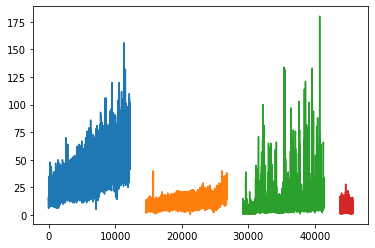

In [11]:
for i in tr_df.Junction.unique().tolist():
    plt.plot(tr_df[tr_df['Junction'] == i].Vehicles)

## Module 6: Exploring Time Series

In [12]:
# Dickey Fuller Test
# Time Series Packages
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=24).mean()
    rolstd = timeseries.rolling(window=24).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

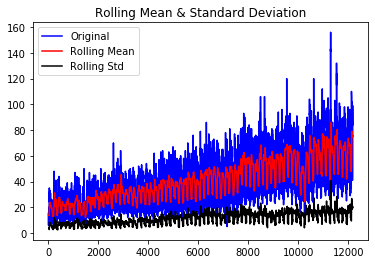

Results of Dickey-Fuller Test:
Test Statistic                   -6.96
p-value                           0.00
#Lags Used                       39.00
Number of Observations Used   12146.00
Critical Value (1%)              -3.43
Critical Value (5%)              -2.86
Critical Value (10%)             -2.57
dtype: float64


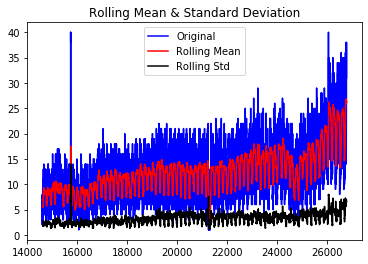

Results of Dickey-Fuller Test:
Test Statistic                   -9.10
p-value                           0.00
#Lags Used                       38.00
Number of Observations Used   12147.00
Critical Value (1%)              -3.43
Critical Value (5%)              -2.86
Critical Value (10%)             -2.57
dtype: float64


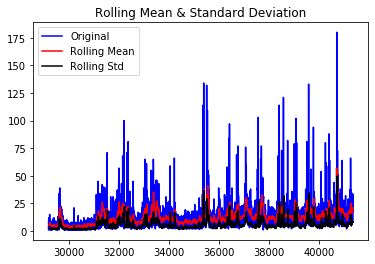

Results of Dickey-Fuller Test:
Test Statistic                   -8.23
p-value                           0.00
#Lags Used                       40.00
Number of Observations Used   12145.00
Critical Value (1%)              -3.43
Critical Value (5%)              -2.86
Critical Value (10%)             -2.57
dtype: float64


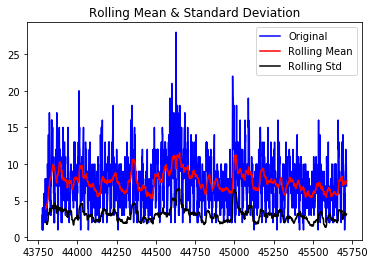

Results of Dickey-Fuller Test:
Test Statistic                  -4.53
p-value                          0.00
#Lags Used                      24.00
Number of Observations Used   1913.00
Critical Value (1%)             -3.43
Critical Value (5%)             -2.86
Critical Value (10%)            -2.57
dtype: float64


In [13]:

for i in tr_df.Junction.unique().tolist():
    ts = tr_df[tr_df['Junction'] == i]['Vehicles']
    test_stationarity(ts)


p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

Error 43.28882272490317
Error 38.74506748026565
Error 71.06912216898806
Error 65.05457079622332


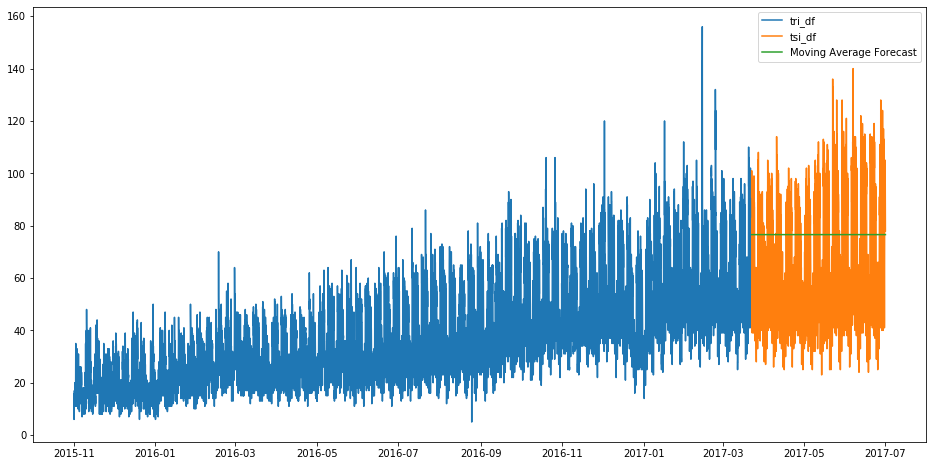

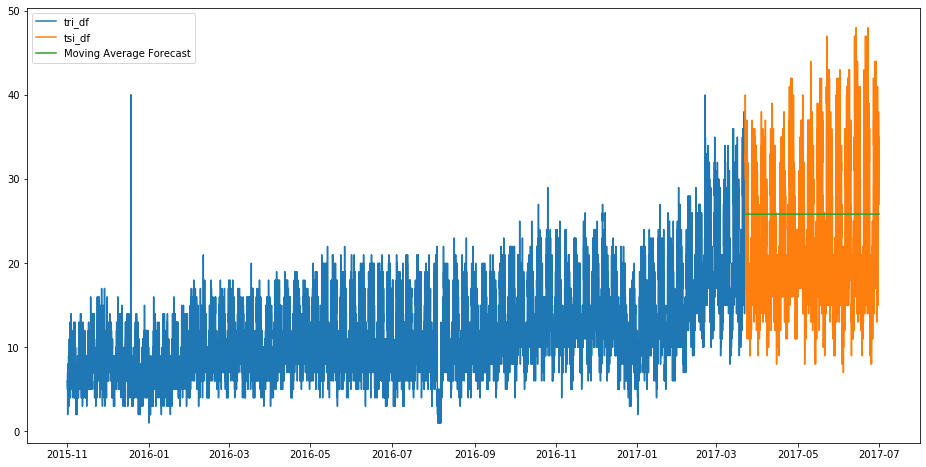

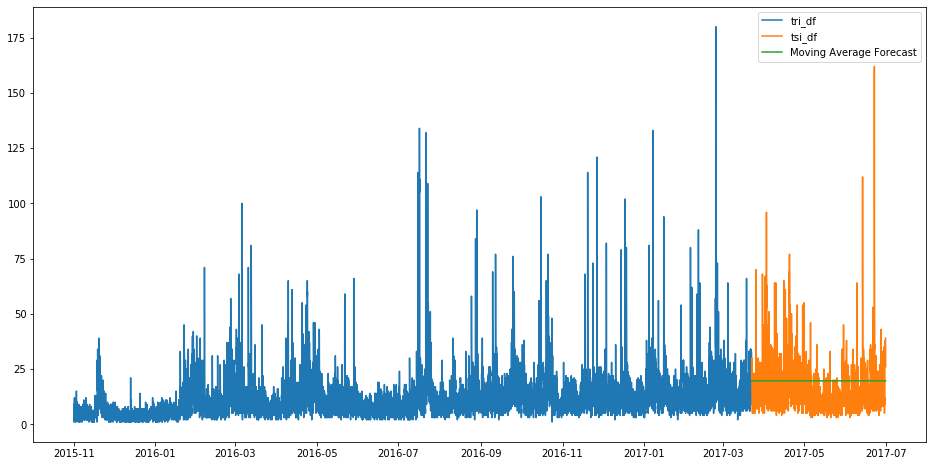

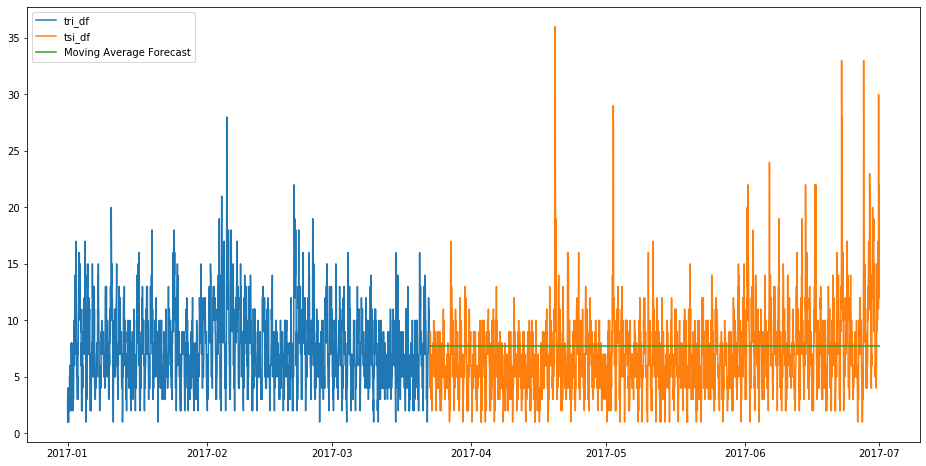

In [14]:
#Method 3 – Moving Average
for i in tr_df.Junction.unique().tolist():
    tri_df = tr_df[tr_df['Junction'] == i].copy()
    tsi_df = test_df[test_df['Junction'] == i].copy()
    y_hat_avg = tsi_df.copy()
    y_hat_avg['moving_avg_forecast'] = tri_df['Vehicles'].rolling(60).mean().iloc[-1]
    
    error = mean_absolute_percentage_error(tsi_df['Vehicles'], y_hat_avg['moving_avg_forecast'])
    
    print("Error", error)
    plt.figure(figsize=(16,8))
    plt.plot(tri_df['ds'], tri_df['Vehicles'], label='tri_df')
    plt.plot(tsi_df['ds'], tsi_df['Vehicles'], label='tsi_df')
    plt.plot(tsi_df['ds'], y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
    plt.legend(loc='best')
plt.show()

## Module 7 : Fit Trained Model

In [15]:
test_df = _ReadCsv_pd(folder, test)

print("Junctions predict for test", test_df.Junction.unique())
print("Dates to predict for test", test_df.DateTime.min(), test_df.DateTime.max())

test_BdBKkAj_L87Nc3S.csv : Read csv to dataframe sucessfully
Shape of dataframe (11808, 3) Memory Usage 1086496
Junctions predict for test [1 2 3 4]
Dates to predict for test 2017-07-01 00:00:00 2017-10-31 23:00:00


In [16]:
ls = []
for i in clean_df.Junction.unique().tolist():
    tri_df = clean_df[clean_df['Junction'] == i].copy()
    tsi_df = test_df[test_df['Junction'] == i].copy()
    y_hat_avg = tsi_df.copy()
    y_hat_avg['moving_avg_forecast'] = tri_df['Vehicles'].rolling(60).mean().iloc[-1]
    ls.append(y_hat_avg)

In [17]:
df = pd.concat(ls)
len(df)

11808

In [18]:
len(test_df)

11808

## Module 9 : Predict

In [19]:
sub_df = _ReadCsv_pd(folder, sub)

sample_submission_KVKNmI7.csv : Read csv to dataframe sucessfully
Shape of dataframe (11808, 2) Memory Usage 189088


In [20]:
submission1 = df[['ID', 'moving_avg_forecast']]
submission1.rename(columns={'moving_avg_forecast': 'Vehicles'}, inplace=True)
submission1.head()

,ID,Vehicles
0,20170701001,87.73
1,20170701011,87.73
2,20170701021,87.73
3,20170701031,87.73
4,20170701041,87.73


In [21]:
output_directory = "./submissions/"
submission1.to_csv(output_directory + "ruhama_submission1.csv", index=False)